In [1]:
from transformers import BertModel, BertTokenizer, AdamWeightDecay, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from textwrap import wrap

In [2]:
# Inicialization of the BERT model
RANDOM_SEED = 42
MAX_LEN = 512 # Máximo de tokens por secuencia
BATCH_SIZE = 16
DATASET_PATH = "historias_clinicas_procesadas.xlsx"
NCLASS = 6

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
print("CUDA disponible:", torch.cuda.is_available())
print("Versión compilada con PyTorch:", torch.version.cuda)
print("Versión de cuDNN:", torch.backends.cudnn.version())
print("Nombre de GPU:", torch.cuda.get_device_name(0))

CUDA disponible: True
Versión compilada con PyTorch: 12.8
Versión de cuDNN: 91002
Nombre de GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
# Cargar dataset

df = pd.read_excel(DATASET_PATH)
df.head()


,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
0,Femenino,38,Otros trastornos,PSICOLOGÍA,"Paciente refiere: ""Me empezaron a dar como uno...","Paciente alerta, colaboradora con apariencia o...","['empezar', 'episodio', 'tom', 'pastilla', 'do...",0,0
1,Masculino,22,T. externalizantes,PSICOLOGÍA,"Paciente refiere ""Me he sentido muy mal, en el...","Paciente a quien evaluó por primera vez, alert...","['sentido', 'trabajar', 'concentrar yo', 'cosa...",1,4
2,Masculino,9,Otros trastornos,PSICOLOGÍA,"La madre refiere ""el viene por un acompañamien...",NaN,"['madre', 'venir', 'acompañamiento', 'emociona...",1,0
3,Masculino,28,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""Estas cosas que han pasado m...","Paciente quien evalúo por primera vez, alerta,...","['cosa', 'problema', 'empresa', 'ocasión', 'sa...",1,0
4,Femenino,8,Otros trastornos,PSICOLOGÍA,"La madre refiere ""Ella ha manifestado ciertas ...","Paciente ingresa en compañía de la madre, aler...","['madre', 'manifestar', 'conducta', 'palabrase...",0,0


In [5]:
df.head()

,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
0,Femenino,38,Otros trastornos,PSICOLOGÍA,"Paciente refiere: ""Me empezaron a dar como uno...","Paciente alerta, colaboradora con apariencia o...","['empezar', 'episodio', 'tom', 'pastilla', 'do...",0,0
1,Masculino,22,T. externalizantes,PSICOLOGÍA,"Paciente refiere ""Me he sentido muy mal, en el...","Paciente a quien evaluó por primera vez, alert...","['sentido', 'trabajar', 'concentrar yo', 'cosa...",1,4
2,Masculino,9,Otros trastornos,PSICOLOGÍA,"La madre refiere ""el viene por un acompañamien...",NaN,"['madre', 'venir', 'acompañamiento', 'emociona...",1,0
3,Masculino,28,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""Estas cosas que han pasado m...","Paciente quien evalúo por primera vez, alerta,...","['cosa', 'problema', 'empresa', 'ocasión', 'sa...",1,0
4,Femenino,8,Otros trastornos,PSICOLOGÍA,"La madre refiere ""Ella ha manifestado ciertas ...","Paciente ingresa en compañía de la madre, aler...","['madre', 'manifestar', 'conducta', 'palabrase...",0,0


In [6]:
# Calcular la longitud máxima de las historias clínicas en términos de número de palabras
max_lenght = df["concatenada"].apply(lambda x: len(x.split())).max()

print(f"La longitud máxima de las historias clínicas es: {max_lenght} palabras.")

La longitud máxima de las historias clínicas es: 965 palabras.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9809 entries, 0 to 9808
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sexo                 9809 non-null   object
 1   edad                 9809 non-null   int64 
 2   grupo                9809 non-null   object
 3   especialidad_medica  9809 non-null   object
 4   subjetivo            9733 non-null   object
 5   objetivo             9774 non-null   object
 6   concatenada          9809 non-null   object
 7   sexo_codificado      9809 non-null   int64 
 8   grupo_codificado     9809 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 689.8+ KB


In [8]:
df.head(10)

,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
0,Femenino,38,Otros trastornos,PSICOLOGÍA,"Paciente refiere: ""Me empezaron a dar como uno...","Paciente alerta, colaboradora con apariencia o...","['empezar', 'episodio', 'tom', 'pastilla', 'do...",0,0
1,Masculino,22,T. externalizantes,PSICOLOGÍA,"Paciente refiere ""Me he sentido muy mal, en el...","Paciente a quien evaluó por primera vez, alert...","['sentido', 'trabajar', 'concentrar yo', 'cosa...",1,4
2,Masculino,9,Otros trastornos,PSICOLOGÍA,"La madre refiere ""el viene por un acompañamien...",NaN,"['madre', 'venir', 'acompañamiento', 'emociona...",1,0
3,Masculino,28,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""Estas cosas que han pasado m...","Paciente quien evalúo por primera vez, alerta,...","['cosa', 'problema', 'empresa', 'ocasión', 'sa...",1,0
4,Femenino,8,Otros trastornos,PSICOLOGÍA,"La madre refiere ""Ella ha manifestado ciertas ...","Paciente ingresa en compañía de la madre, aler...","['madre', 'manifestar', 'conducta', 'palabrase...",0,0
5,Masculino,30,T. externalizantes,PSICOLOGÍA,"Paciente refiere ""yo creo como todo comienza d...","Paciente quien evalúo por primera vez, pacien...","['comenzar', 'crianza', 'mama', 'diagnostico',...",1,4
6,Femenino,60,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""hace 3 años me separe, hace ...","Paciente quien evalúo por primera vez, pacient...","['año', 'separar', 'año', 'hija', 'tambin', 't...",0,0
7,Masculino,57,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""Yo he sido muy introvertido,...","Paciente quien evalúo por primera vez, pacient...","['introvertido', 'expresar', 'sentimiento', 't...",1,0
8,Femenino,25,T. externalizantes,PSICOLOGÍA,"Hace un mes empece a sentir ansiedad, tuve com...","Paciente quien evalúo por primera vez, pacient...","['mes', 'empece', 'sentir', 'ansiedad', 'tener...",0,4
9,Femenino,40,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""en los 15 de mi prima yo le ...","Paciente quien evalúo por primera vez, la cons...","['primar', 'llevar', 'comida', 'tiro', 'marco'...",0,0


In [9]:
# Removemos los corchetes
df["concatenada"] = df["concatenada"].apply(lambda x: str(x).replace("[","").replace("]",""))

# Removemos las comillas simples
df["concatenada"] = df["concatenada"].apply(lambda x: str(x).replace("'",""))

# Unimos las palabras separadas por comas
df["concatenada"] = df["concatenada"].apply(lambda x: str(x).replace(","," "))

In [10]:
df.head()

,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
0,Femenino,38,Otros trastornos,PSICOLOGÍA,"Paciente refiere: ""Me empezaron a dar como uno...","Paciente alerta, colaboradora con apariencia o...",empezar episodio tom pastilla dormir tene...,0,0
1,Masculino,22,T. externalizantes,PSICOLOGÍA,"Paciente refiere ""Me he sentido muy mal, en el...","Paciente a quien evaluó por primera vez, alert...",sentido trabajar concentrar yo cosa vidato...,1,4
2,Masculino,9,Otros trastornos,PSICOLOGÍA,"La madre refiere ""el viene por un acompañamien...",NaN,madre venir acompañamiento emocional sepra...,1,0
3,Masculino,28,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""Estas cosas que han pasado m...","Paciente quien evalúo por primera vez, alerta,...",cosa problema empresa ocasión saludar sal...,1,0
4,Femenino,8,Otros trastornos,PSICOLOGÍA,"La madre refiere ""Ella ha manifestado ciertas ...","Paciente ingresa en compañía de la madre, aler...",madre manifestar conducta palabrasello rel...,0,0


In [11]:
from transformers import BertTokenizer, BertModel

# TOKENIZACION

PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
# Ejemplos de tokenización

sample_text = "Hola soy un texto de ejemplo para la tokenización."
tokens = tokenizer.tokenize(sample_text)
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"Texto original: {sample_text}")
print(f"Tokens: {tokens}")
print(f"IDs de tokens: {tokens_ids}")

Texto original: Hola soy un texto de ejemplo para la tokenización.
Tokens: ['Ho', '##la', 'soy', 'un', 'texto', 'de', 'ejemplo', 'para', 'la', 'tok', '##eni', '##zación', '.']
IDs de tokens: [20220, 10330, 103559, 10119, 27888, 10104, 20223, 10220, 10109, 18436, 18687, 23700, 119]


In [13]:
# Codificacion para introducir a BERT

encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    return_token_type_ids=False,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [14]:
encoding.keys()

KeysView({'input_ids': tensor([[   101,  20220,  10330, 103559,  10119,  27888,  10104,  20223,  10220,
          10109,  18436,  18687,  23700,    119,    102,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
     

In [15]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"][0]))
print(encoding["input_ids"][0])
print(encoding["attention_mask"][0])

['[CLS]', 'Ho', '##la', 'soy', 'un', 'texto', 'de', 'ejemplo', 'para', 'la', 'tok', '##eni', '##zación', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

In [16]:
# CREACION DEL DATASET

class CustomDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_len):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
      return len(self.text)

    def __getitem__(self, item):
      text = str(self.text[item])
      label = self.labels[item]
      encoding = tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors="pt",
      )
      return {"text": text,
                "input_ids": encoding["input_ids"].flatten(),
                "attention_mask": encoding["attention_mask"].flatten(),
                "labels": torch.tensor(label, dtype=torch.long)}


In [17]:
df.columns

Index(['sexo', 'edad', 'grupo', 'especialidad_medica', 'subjetivo', 'objetivo',
       'concatenada', 'sexo_codificado', 'grupo_codificado'],
      dtype='object')

In [18]:
# Data Loader function

def data_loader(df, tokenizer, max_len, batch_size):
    dataset = CustomDataset(
        text = df["concatenada"].to_numpy(),
        labels = df["grupo_codificado"].to_numpy(),
        tokenizer = tokenizer,
        max_len = MAX_LEN
    )
    return DataLoader(dataset, batch_size = BATCH_SIZE, pin_memory=True)


In [19]:
# Split del dataset en train y test

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
# Red Neuronal para el modelo BERT

class BERTTextClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTTextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # Inicialización del modelo BERT preentrenado
        self.dropout = nn.Dropout(0.3) # Dropout para evitar overfitting
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) # Número de clases de salida

    def forward(self, input_ids, attention_mask):
      outputs = self.bert(
          input_ids = input_ids,
          attention_mask = attention_mask
      )
      pooled_out = outputs.pooler_output
      drop_out = self.dropout(pooled_out) # Aplicar dropout
      output = self.linear(drop_out) # Capa lineal para la clasificación
      return output


In [21]:
model = BERTTextClassifier(NCLASS)
model = model.to(device)

In [22]:
print(model)

BERTTextClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [23]:
# ENTRENAMIENTO

EPOCHS = 10
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device) # Función de pérdida para clasificación multiclase

In [24]:
# Iteracion de Entranamiento

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses) # Pérdida promedio

In [25]:
len(df_train)

7847

In [26]:
import time
from tqdm.notebook import tqdm

# Lista para almacenar metricas de entrenamiento
train_losses_history = []
train_accuracies_history = []
val_losses_history = []
val_accuracies_history = []

# Entrenamiento del Modelo con barras de progreso
for epoch in range(EPOCHS):
  print("Epoch {} de {}".format(epoch + 1, EPOCHS))
  print("-----------------------------------")
  start_time = time.time()
  
  # --- Training loop with tqdm ---
  model.train()
  train_losses = []
  train_correct = 0
  train_total = len(df_train)

  train_iter = tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Train", leave=False)
  for batch in train_iter:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    train_correct += torch.sum(preds == labels)
    train_losses.append(loss.item())

    loss.backward() 
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    train_iter.set_postfix(loss=np.mean(train_losses), acc=(train_correct.double() / train_total).item())

  train_acc = train_correct.double() / train_total
  train_loss = np.mean(train_losses)

  # --- Evaluation loop with tqdm ---
  model.eval()
  test_losses = []
  test_correct = 0
  test_total = len(df_test)

  eval_iter = tqdm(test_data_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Eval", leave=False)
  with torch.no_grad():
    for batch in eval_iter:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)

      test_correct += torch.sum(preds == labels)
      test_losses.append(loss.item())

      eval_iter.set_postfix(loss=np.mean(test_losses), acc=(test_correct.double() / test_total).item())

  test_acc = test_correct.double() / test_total
  test_loss = np.mean(test_losses)
  
  # Almacenar métricas de la época
  train_losses_history.append(train_loss)
  train_accuracies_history.append(train_acc.item())
  val_losses_history.append(test_loss)
  val_accuracies_history.append(test_acc.item())

  end_time = time.time()

  print("Entramiento: Loss: {:.4f}, accuracy: {:.4f}".format(train_loss, train_acc))
  print("Evaluacion: Loss: {:.4f}, accuracy: {:.4f}".format(test_loss, test_acc))
  print(f"Tiempo de la época: {end_time - start_time:.2f} segundos")
  print("")


Epoch 1 de 10
-----------------------------------


Epoch 1/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 1/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 1.5811, accuracy: 0.3400
Evaluacion: Loss: 1.6201, accuracy: 0.3058
Tiempo de la época: 1718.60 segundos

Epoch 2 de 10
-----------------------------------


Epoch 2/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 2/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 1.3932, accuracy: 0.4302
Evaluacion: Loss: 1.4370, accuracy: 0.4169
Tiempo de la época: 1639.48 segundos

Epoch 3 de 10
-----------------------------------


Epoch 3/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 3/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 1.2590, accuracy: 0.5038
Evaluacion: Loss: 1.3186, accuracy: 0.4888
Tiempo de la época: 1386.42 segundos

Epoch 4 de 10
-----------------------------------


Epoch 4/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 4/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 1.1046, accuracy: 0.5866
Evaluacion: Loss: 1.2982, accuracy: 0.5143
Tiempo de la época: 1381.78 segundos

Epoch 5 de 10
-----------------------------------


Epoch 5/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 5/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 0.9567, accuracy: 0.6473
Evaluacion: Loss: 1.3053, accuracy: 0.5336
Tiempo de la época: 1382.91 segundos

Epoch 6 de 10
-----------------------------------


Epoch 6/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 6/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 0.8302, accuracy: 0.7038
Evaluacion: Loss: 1.3199, accuracy: 0.5622
Tiempo de la época: 1382.34 segundos

Epoch 7 de 10
-----------------------------------


Epoch 7/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 7/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 0.7083, accuracy: 0.7554
Evaluacion: Loss: 1.3850, accuracy: 0.5591
Tiempo de la época: 1380.90 segundos

Epoch 8 de 10
-----------------------------------


Epoch 8/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 8/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 0.6131, accuracy: 0.7941
Evaluacion: Loss: 1.3526, accuracy: 0.5805
Tiempo de la época: 1381.07 segundos

Epoch 9 de 10
-----------------------------------


Epoch 9/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 9/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 0.5365, accuracy: 0.8212
Evaluacion: Loss: 1.4059, accuracy: 0.5749
Tiempo de la época: 1383.01 segundos

Epoch 10 de 10
-----------------------------------


Epoch 10/10 - Train:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 10/10 - Eval:   0%|          | 0/123 [00:00<?, ?it/s]

Entramiento: Loss: 0.4763, accuracy: 0.8429
Evaluacion: Loss: 1.4250, accuracy: 0.5846
Tiempo de la época: 1382.40 segundos



# Guardar el modelo

In [27]:
# Guardar el modelo entrenado para usarlo posteriormente

model_path = "bert_text_classifier_model.pth"

torch.save(model.state_dict(), model_path)

# Grafico de Loss y Accuracy 

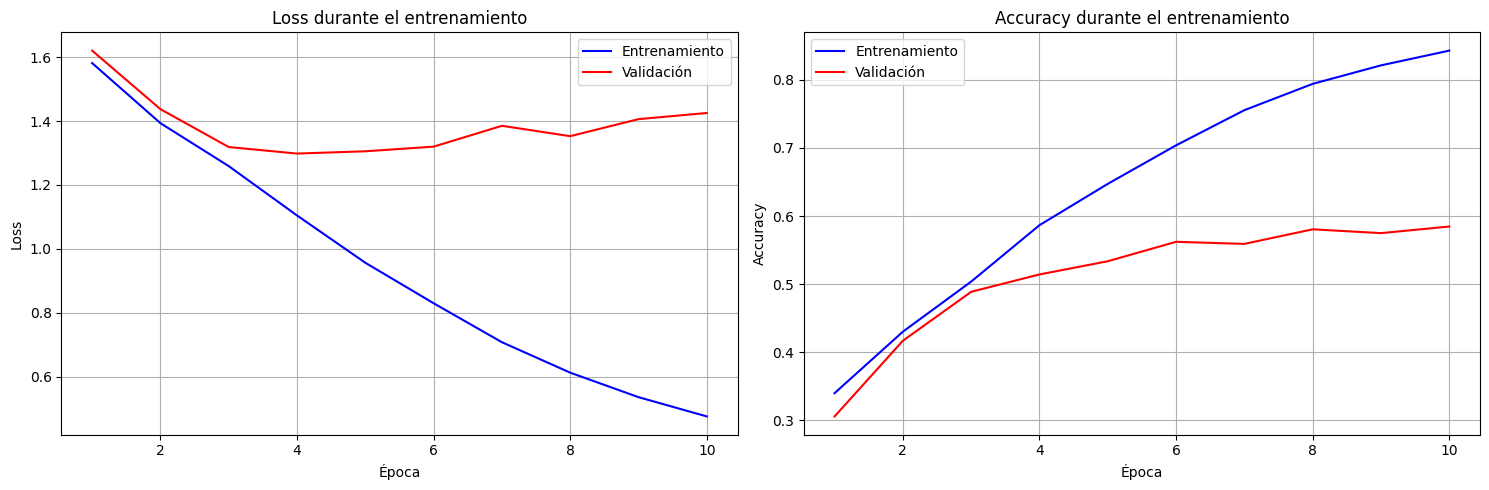

In [28]:
# Grafico de Loss y Accuracy
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(epochs, train_losses_history, "b-", label="Entrenamiento")
ax1.plot(epochs, val_losses_history, "r-", label="Validación")
ax1.set_title("Loss durante el entrenamiento")
ax1.set_xlabel("Época")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(epochs, train_accuracies_history, "b-", label="Entrenamiento")
ax2.plot(epochs, val_accuracies_history, "r-", label="Validación")
ax2.set_title("Accuracy durante el entrenamiento")
ax2.set_xlabel("Época")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()

# Guardar la figura
plt.savefig("training_validation_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

# Preprocesamiento Historia Clinica

In [29]:
import re
import spacy
from spacy.lang.es.stop_words import STOP_WORDS as stopwords

def expresiones_regulares(texto: str) -> str:
    # Remove accents/tildes but keep the letters
    texto = re.sub(r'[áàäâã]', 'a', texto)
    texto = re.sub(r'[éèëê]', 'e', texto)
    texto = re.sub(r'[íìïî]', 'i', texto)
    texto = re.sub(r'[óòöôõ]', 'o', texto)
    texto = re.sub(r'[úùüû]', 'u', texto)
    texto = re.sub(r'[ÁÀÄÂÃ]', 'A', texto)
    texto = re.sub(r'[ÉÈËÊ]', 'E', texto)
    texto = re.sub(r'[ÍÌÏÎ]', 'I', texto)
    texto = re.sub(r'[ÓÒÖÔÕ]', 'O', texto)
    texto = re.sub(r'[ÚÙÜÛ]', 'U', texto)
    
    # Convert to lowercase, remove non-alphabetic characters except spaces and ñ/ü, normalize spaces
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zñü ]', '', texto.lower())).strip()


def tokenizar(texto: str) -> str:
    nlp = spacy.load("es_core_news_lg")
    
    stopwords_personalizados = [
        "medico", "paciente", "psicologo", "psicologa",
        "psicologia", "psicoterapeuta", "psicoterapia", "refiere"
    ]
    all_stopwords = stopwords.union(stopwords_personalizados)
    
    tokens = [
        token.text for token in nlp(texto)
        if token.text.lower() not in all_stopwords and not token.is_punct and not token.is_space
    ]
    
    return " ".join(tokens)


def lematizar(texto: str) -> str:
    nlp = spacy.load("es_core_news_lg")
    
    tokens = texto.split()
    lemmas = [token.lemma_ for token in nlp(" ".join(tokens))]
    
    return " ".join(lemmas)

texto_a_predecir = "estos días han sido un poquito maluquitos, tratando de asimilar lo de su hijo continua muy deprimida y la situación con su esposo continua muy abrumadora, siente mucho abuso psicológico porque el es quien paga el arriendo y la paciente no quiere tener relación con él, nombra toda la vida este hombre a tomado mucho trago, y no quiero estar con él. Ha tenido llanto fácil, pensamientos con su hijo, se siente muy mal porque no tiene dinero, ni pasajes. Continua con alteraciones en el sueño y alimentacion. Esta pendiente  la cita con psiquiatría y trabajo social.  Paciente se escucha con actitud abierta, se encuentra orientada en sus tres esferas: en persona, tiempo y lugar, euproséxica, alerta, con pensamiento estructurado, afecto eutimico, con pensamiento o plan suicida, lenguaje fluido, coherente y tono de voz normal, con alteraciones del sueño y de alimentacion, niega alteraciones sensoriales, juicio comprometido, introspección y con prospección en elaboración."

texto_limpio = expresiones_regulares(texto_a_predecir)
texto_tokenizado = tokenizar(texto_limpio)
texto_lemmatizado = lematizar(texto_tokenizado)

print("Texto Original:", texto_a_predecir)
print("Texto Lematizado:", texto_lemmatizado)


Texto Original: estos días han sido un poquito maluquitos, tratando de asimilar lo de su hijo continua muy deprimida y la situación con su esposo continua muy abrumadora, siente mucho abuso psicológico porque el es quien paga el arriendo y la paciente no quiere tener relación con él, nombra toda la vida este hombre a tomado mucho trago, y no quiero estar con él. Ha tenido llanto fácil, pensamientos con su hijo, se siente muy mal porque no tiene dinero, ni pasajes. Continua con alteraciones en el sueño y alimentacion. Esta pendiente  la cita con psiquiatría y trabajo social.  Paciente se escucha con actitud abierta, se encuentra orientada en sus tres esferas: en persona, tiempo y lugar, euproséxica, alerta, con pensamiento estructurado, afecto eutimico, con pensamiento o plan suicida, lenguaje fluido, coherente y tono de voz normal, con alteraciones del sueño y de alimentacion, niega alteraciones sensoriales, juicio comprometido, introspección y con prospección en elaboración.
Texto Lem

# Cargar el modelo

In [30]:
# Cargar el modelo guardado y hacer una predicción

model_path = "bert_text_classifier_model.pth"

model = BERTTextClassifier(NCLASS)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

BERTTextClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

# Prediccion Trastorno

In [31]:
# Mapeo de clases
label_map = {
    0: "Otros Trastornos",
    1: "T. de adaptación",
    2: "T. de ansiedad",
    3: "T. depresivos",
    4: "T. externalizantes",
    5: "T. personalidad"
}

def classify_text(text):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        
    return predicted_class.item(), probabilities[0].cpu().numpy()


# Realizar la predicción
predicted_class, all_probabilities = classify_text(texto_lemmatizado)

print(f"\nClase predicha: {predicted_class} - {label_map[predicted_class]}")
print(f"Confianza: {all_probabilities[predicted_class]:.4f}\n")

print("Probabilidades para todas las clases:")
print("-" * 50)
for class_id, prob in enumerate(all_probabilities):
    print(f"{label_map[class_id]:25s}: {prob:.4f} ({prob*100:.2f}%)")


Clase predicha: 3 - T. depresivos
Confianza: 0.9016

Probabilidades para todas las clases:
--------------------------------------------------
Otros Trastornos         : 0.0026 (0.26%)
T. de adaptación         : 0.0032 (0.32%)
T. de ansiedad           : 0.0878 (8.78%)
T. depresivos            : 0.9016 (90.16%)
T. externalizantes       : 0.0010 (0.10%)
T. personalidad          : 0.0038 (0.38%)
